In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/2809496124_5f25b5946a.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/2438480600_40a1249879.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/181171681_c5a1a82ded.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/abeja.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/26589803_5ba7000313.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/2709775832_85b4b50a57.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/238161922_55fa9a76ae.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/2670536155_c170f49cd0.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/2501530886_e20952b97d.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/1355974687_1341c1face.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/val/bees/576452297_897023f002.jpg
/kaggle/input/hymenoptera

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [38]:
data_dir = '../input/hymenoptera-data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [18]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [16]:
inputs, classes = next(iter(data_loaders['train']))

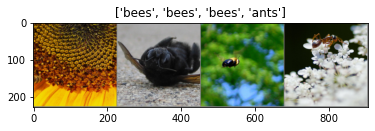

In [19]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [29]:
model = model.to(device)

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [39]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6642 Acc: 0.6270
val Loss: 0.4760 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.5112 Acc: 0.7869
val Loss: 0.3526 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4427 Acc: 0.8402
val Loss: 0.2804 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4183 Acc: 0.8279
val Loss: 0.2591 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4233 Acc: 0.7787
val Loss: 0.2270 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4189 Acc: 0.7910
val Loss: 0.2072 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3721 Acc: 0.8484
val Loss: 0.2059 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3512 Acc: 0.8484
val Loss: 0.2018 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3462 Acc: 0.8648
val Loss: 0.1978 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3672 Acc: 0.8402
val Loss: 0.1976 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3414 Acc: 0.8525
val Loss: 0.2008 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3563 Acc: 0.8197
val Loss: 0.1986 Acc: 0.9346

Ep

In [40]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [41]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)